In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import time
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

print(cv2.__version__)
sift  = cv2.xfeatures2d.SIFT_create()

3.4.1


68783.jpg


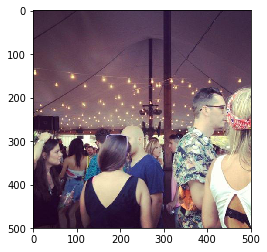

In [2]:
img = cv2.imread("training_set/2.jpg")
# print(img)
sift_dict = {}
for filename in os.listdir('training_set/'):
    print(filename)
    img = cv2.imread('training_set/'+filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    break

In [3]:
#CSV file reading
"""
Generating dictionaries
for photo_id ---> buisness_id
"""
photo_to_bus_dict = {}
with open('train_photo_to_biz_ids.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            photo_to_bus_dict[row[0]] = row[1]
            line_count += 1
    print(f'Processed {line_count} lines.')
print(len(photo_to_bus_dict))
    
"""
Generating dictionaries
for business_id ---> labels
"""
bus_to_labels_dict = {}     
with open('train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            bus_to_labels_dict[row[0]] = [row[1]]
            line_count += 1
    print(f'Processed {line_count} lines.')  
print(len(bus_to_labels_dict))

"""
Checking the distribution of labels
in the training set
"""
hist_label = [0]*9
for filename in os.listdir('training_set'):
    photo_id = filename.split('.')
    lst_labels = bus_to_labels_dict[photo_to_bus_dict[photo_id[0]]]
    labels = lst_labels[0].split(' ')
    if len(labels)!=0:
        for i in labels:
            if i is not '':
                hist_label[int(i)]+=1

print("Histogram distribution for the labels in the training_set")
print(hist_label)

Column names are photo_id, business_id
Processed 234843 lines.
234842
Column names are business_id, labels
Processed 2001 lines.
2000
Histogram distribution for the labels in the training_set
[9163, 23679, 25603, 19453, 16829, 29454, 30772, 14825, 20300]


In [4]:
"""
Get the training data
Returns images and respective photo ids
"""
def get_train_data():
    data = []
    photo_ids = []
    count=0
    for filename in sorted(os.listdir('training_set/'),key=lambda x: int(os.path.splitext(x)[0])):
        if count%5000==4999:
            print(filename)
        photo_ids.append(filename.split('.')[0])
        data.append(cv2.imread('training_set/'+filename,0))
        count+=1
    return data,photo_ids
    
train_data, train_photo_ids = get_train_data()
print(len(train_data))

10195.jpg
20062.jpg
29986.jpg
40137.jpg
50092.jpg
59987.jpg
70098.jpg
79934.jpg
40000


In [5]:
"""
Get the testing data
Returns images and respective photo ids
"""
def get_test_data():
    data = []
    photo_ids = []
    count=0
    for filename in sorted(os.listdir('testing_set/'),key=lambda x: int(os.path.splitext(x)[0])):
        if count%5000==4999:
            print(filename)
        photo_ids.append(filename.split('.')[0])
        data.append(cv2.imread('testing_set/'+filename,0))
        count+=1
    return data,photo_ids
    
test_data, test_photo_ids = get_test_data()
print(len(test_data))

461953.jpg
471994.jpg
10000


In [6]:
"""
Creates no_images*labels_size matrix
with each row indicating what labels
are assigned to each photo
"""
def id_to_label(photo_ids):
    photo_labels = np.empty(shape=[0,9])
    for id in photo_ids:
        lst_labels = bus_to_labels_dict[photo_to_bus_dict[id]]
        ls = lst_labels[0].split(' ')
        labels = [0]*9
        for label in ls:
            if label !='':
                labels[int(label)] = 1
        labels = np.array(labels).reshape(1,-1)
        photo_labels = np.append(photo_labels,labels,axis=0)
    return photo_labels

In [7]:
#Training set
"""
Contains no_images*labels_size matrix
with each row indicating what labels
are assigned to each photo
"""
train_photo_labels = id_to_label(train_photo_ids)
print(train_photo_labels[0])
print(bus_to_labels_dict[photo_to_bus_dict[train_photo_ids[0]]])
print(train_photo_labels.shape)
print(train_photo_labels[:,0].shape)

[ 0.  1.  1.  0.  1.  1.  1.  1.  0.]
['1 2 4 5 6 7']
(40000, 9)
(40000,)


In [8]:
#Testing set
"""
Contains no_images*labels_size matrix
with each row indicating what labels
are assigned to each photo
"""
test_photo_labels = id_to_label(test_photo_ids)
print(test_photo_labels[0])
print(bus_to_labels_dict[photo_to_bus_dict[test_photo_ids[0]]])
print(test_photo_labels.shape)
print(test_photo_labels[:,0].shape)

[ 0.  0.  0.  1.  0.  0.  0.  0.  1.]
['3 8']
(10000, 9)
(10000,)


In [15]:
"""
Function that does the extraction of dense SIFT descriptors
params: 
   data:   vector of images       
return:
    temp_des: vector of descriptors for invidual image
    des:      a combined matrix of all images
"""
"""
Parameters to be considered step and scale.
"""
step = 50
scale = 20
def get_dense_descriptors(data):
    temp_des = []
    des = np.empty(shape=[0,128])
    for i in data:
        kp = [cv2.KeyPoint(y, x,scale) for y in range(0, i.shape[0], step) 
                                for x in range(0, i.shape[1], step)]
        kp, dense_feat = sift.compute(i, kp)
        dense_feat = np.array(dense_feat)
        temp_des.append(dense_feat)
        des = np.append(des,dense_feat,axis=0)
    return temp_des, des 

In [16]:
"""
Extracting descriptors for training data
"""
t0 = time.time()
train_individual_des, train_des = get_dense_descriptors(train_data)
print("Shape of overall training images descriptors:-")
print(train_des.shape)
print("Extracting training images descriptors took %0.3fs." % (time.time() - t0))

filename = "descriptors_train"+str(step)+"_step_"+str(scale)+"_scale.pkl"  

pickle.dump((train_individual_des, train_des),open(filename,'wb'))

# pickle.dump([train_individual_des, train_des],open(filename,'wb'))

print("write descriptors train finished")

Shape of overall training images descriptors:-
(3132260, 128)
Extracting training images descriptors took 56257.478s.
write descriptors train finished


In [3]:
train_individual_des, train_des = pickle.load(open("descriptors_train50_step_20_scale.pkl",'rb'))

In [17]:
"""
Extracting descriptors for testing data
"""
t0 = time.time()
test_individual_des, test_des = get_dense_descriptors(test_data)
print("Shape of overall test images descriptors:-")
print(test_des.shape)
print("Extracting test images descriptors took %0.3fs." % (time.time() - t0))


filename = "descriptors_test"+str(step)+"_step_"+str(scale)+"_scale.pkl"  

pickle.dump((test_individual_des, test_des),open(filename,'wb'))
print("write descriptors test finished")

Shape of overall test images descriptors:-
(782829, 128)
Extracting test images descriptors took 3616.066s.
write descriptors test finished


In [10]:
test_individual_des, test_des = pickle.load(open("descriptors_test50_step_20_scale.pkl",'rb'))

In [18]:
"""
Generating cluster using K-Means
"""
t0 = time.time()
no_clusters = 50
kmeans = KMeans(no_clusters).fit(train_des)
print("Training the K-Means clustering took %0.3fs." % (time.time() - t0))

filename = "clusters/bov_pickle_new_"+str(no_clusters)+"_step_"+str(step)+"_scale_"+str(scale)+".sav"
pickle.dump(kmeans, open(filename, 'wb'))
print("Model saved to file: " + str(filename))

Training the K-Means clustering took 11268.208s.
Model saved to file: clusters/bov_pickle_new_50_step_50_scale_20.sav


In [12]:
"""
Generating histograms for train/test
based on the clusters that we get K-Means
"""

kmeans = pickle.load(open("clusters/bov_pickle_new_50_step_50_scale_20.sav",'rb'))


def create_histogram(individual_data, kmeans,no_clusters):
    hist = np.empty(shape=[0,no_clusters])
    for i in individual_data:
        pred_te = kmeans.predict(i)
        h = np.histogram(pred_te,bins = np.arange(0,no_clusters+1))
        total = i.shape[0]
        tmp = []
        for j in range(0,no_clusters):
            tmp.append(h[0][j])
        tmp = np.asarray(tmp)
        tmp = tmp.reshape(1, no_clusters)
        tmp = tmp/(total*1.0)
        hist= np.append(hist,tmp,axis=0)
    return hist

In [13]:
#For loading the model
kmeans = pickle.load(open("clusters/bov_pickle_50_step_15_scale_20.sav", 'rb'))
no_clusters = 50

"""
Creating histograms or Bag of visual words
for training and testing descriptors using K-Means cluster from before
"""
t0 = time.time()
train_hist = create_histogram(train_individual_des, kmeans, no_clusters)
test_hist = create_histogram(test_individual_des, kmeans, no_clusters)
print("Calculating histograms took %0.3fs." % (time.time() - t0))

Calculating histograms took 191.204s.


In [14]:
"""
Training 9 random classifiers sperately for each label as a target
"""
t0 = time.time()

Ypred = []
num_classes = 9
clf = [None]*num_classes
for i in range(num_classes):
    print("creating classifier:",i)
    rf = RandomForestClassifier(n_estimators=300,n_jobs=-1,oob_score=True,criterion="entropy")
    print("fitting classifier:",i)
    rf.fit(train_hist, train_photo_labels[:,i])
    print("getting predictions for attribute:",i)
    y_pred = rf.predict(test_hist)
    Ypred.append(y_pred)
  
print("Training took %0.3fs." % (time.time() - t0))
print("preparing output...")
Ypred = np.vstack(Ypred)
Ypred = np.transpose(Ypred)
Ypred = Ypred.tolist()

creating classifier: 0
fitting classifier: 0
getting predictions for attribute: 0
creating classifier: 1
fitting classifier: 1
getting predictions for attribute: 1
creating classifier: 2
fitting classifier: 2
getting predictions for attribute: 2
creating classifier: 3
fitting classifier: 3
getting predictions for attribute: 3
creating classifier: 4
fitting classifier: 4
getting predictions for attribute: 4
creating classifier: 5
fitting classifier: 5
getting predictions for attribute: 5
creating classifier: 6
fitting classifier: 6
getting predictions for attribute: 6
creating classifier: 7
fitting classifier: 7
getting predictions for attribute: 7
creating classifier: 8
fitting classifier: 8
getting predictions for attribute: 8
Training took 98.360s.
preparing output...
10000


In [22]:
def verify_correctness(pred1, test_labels, threshold=0):
    cnt=0
    for x, y in zip(pred1, test_labels):
        x1= np.array(x)
        y1 = np.array(y)
        c=0
        for a, b in zip(x1, y1):
            if(a!=b): c+=1
        if c<=threshold:
            cnt+=1
    accuracy = cnt/len(test_labels)
    return accuracy

In [2]:
print("Accuracy score for strict match is ",verify_correctness(Ypred,test_photo_labels,0)*100)   #Strict match
print("Accuracy score for maximum of 1 mistmatch is ", verify_correctness(Ypred,test_photo_labels,1)*100)   # One mismatch
print("Accuracy score for maximum of 2 mistmatch is ",verify_correctness(Ypred,test_photo_labels,2)*100)   # Two mismatch

Accuracy score for strict match is 36.7031
Accuracy score for maximum of 1 mistmatch is 40.8372
Accuracy score for maximum of 2 mistmatch is 51.2016
